# Zadanie 4: RNN - Suma wartości w sekwencji

## 📝 Opis zadania
**Dane wejściowe:**
- 30 sekwencji (ile przykładów mamy do uczenia)
- Każda sekwencja ma 20 kroków czasowych (długość sekwencji)
- Wartości są losowe, zaokrąglone do: **0.33, 0.66 lub 1**

**Cel:** Model ma przewidzieć **sumę wszystkich liczb** w sekwencji.

---

## 🎯 Przykład
Jeśli mamy sekwencję: `[0.33, 1, 0.66, 1, 0.33, ...]` (20 liczb)  
To target `t` = 0.33 + 1 + 0.66 + 1 + 0.33 + ... = **suma wszystkich wartości**

---

## 🔧 Parametry modelu RNN

### Wagi (Weights):
- **`wx`** (waga wejściowa) - określa, jak mocno bieżący krok czasowy wpływa na stan sieci
- **`wRec`** (waga rekurencyjna) - określa, jak mocno poprzedni stan wpływa na obecny stan

### Wzór RNN:
$$S_k = S_{k-1} \cdot W_{rec} + X_k \cdot W_x$$

Gdzie:
- $S_k$ = stan w kroku k
- $S_{k-1}$ = stan w poprzednim kroku  
- $X_k$ = wartość wejściowa w kroku k
- $W_{rec}$ = waga rekurencyjna (jak "zapamiętujemy" przeszłość)
- $W_x$ = waga wejściowa (jak reagujemy na nowe dane)

---

## ⚙️ Parametry optymalizacji RProp

**RProp** (Resilient Propagation) - inteligentny algorytm uczenia:

- **`eta_p`** = 1.2 - jeśli gradient ma ten sam znak co poprzednio, **zwiększ** krok o 20%
- **`eta_n`** = 0.5 - jeśli gradient zmienił znak (przeskoczyliśmy minimum), **zmniejsz** krok o 50%

**Dlaczego RProp?**  
Zwykły gradient descent może mieć problem z "wybuchającymi" lub "znikającymi" gradientami w RNN. RProp dostosowuje wielkość kroku dla każdej wagi osobno.

---

## 📊 Co zobaczysz na wykresach?

1. **Loss Surface** - powierzchnia błędu w zależności od wag
   - Jaśniejsze obszary = większy błąd
   - Ciemniejsze obszary = mniejszy błąd
   - Białe punkty = ścieżka optymalizacji
   - Gwiazdka = końcowe wagi

2. **Gradient over time** - jak gradient zmienia się wstecz w czasie
   - Pokazuje problem "vanishing/exploding gradients"
   - Dla różnych początkowych wag widzimy różne zachowania

In [2]:
# Importy bibliotek
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np  # Obliczenia na macierzach i wektorach
import matplotlib
import matplotlib.pyplot as plt  # Rysowanie wykresów
from matplotlib import cm  # Mapy kolorów
from matplotlib.colors import LogNorm
import seaborn as sns  # Ładniejsze wykresy

# Ustawienie stylu wykresów
sns.set_style('darkgrid')
# Ustawienie ziarna losowości dla powtarzalności wyników
np.random.seed(seed=1)

## 1️⃣ Tworzenie zbioru danych

**Parametry:**
- `nb_of_samples` = 30 → ile sekwencji (przykładów treningowych)
- `sequence_len` = 20 → długość każdej sekwencji (ile kroków czasowych)

**Proces:**
1. Generujemy liczby losowe z przedziału [0, 1]
2. Zaokrąglamy je do najbliższej wartości: 0.33, 0.66 lub 1
3. Obliczamy sumę dla każdej sekwencji jako target

In [3]:
# Tworzenie zbioru danych
nb_of_samples = 30  # Liczba sekwencji (przykładów)
sequence_len = 20   # Długość każdej sekwencji (kroki czasowe)

# Tworzymy macierz na sekwencje
X = np.zeros((nb_of_samples, sequence_len))

# Wypełniamy każdą sekwencję wartościami 0.33, 0.66 lub 1
for row_idx in range(nb_of_samples):
    # Losujemy liczby z przedziału [0, 1]
    random_values = np.random.rand(sequence_len)
    # Zaokrąglamy do 0.33, 0.66 lub 1
    # 0-0.33 -> 0.33, 0.33-0.66 -> 0.66, 0.66-1 -> 1
    X[row_idx, :] = np.round(random_values * 3) / 3
    # Zamieniamy 0 na 0.33
    X[row_idx, :][X[row_idx, :] == 0] = 0.33

# Tworzymy targety - suma wartości w każdej sekwencji
t = np.sum(X, axis=1)

print(f"Kształt danych wejściowych X: {X.shape}")
print(f"Przykładowa sekwencja: {X[0]}")
print(f"Suma dla tej sekwencji: {t[0]:.2f}")
print(f"\nMinimalna możliwa suma: {20 * 0.33:.2f}")
print(f"Maksymalna możliwa suma: {20 * 1.0:.2f}")

Kształt danych wejściowych X: (30, 20)
Przykładowa sekwencja: [0.33333333 0.66666667 0.33       0.33333333 0.33       0.33
 0.33333333 0.33333333 0.33333333 0.66666667 0.33333333 0.66666667
 0.33333333 1.         0.33       0.66666667 0.33333333 0.66666667
 0.33       0.33333333]
Suma dla tej sekwencji: 8.98

Minimalna możliwa suma: 6.60
Maksymalna możliwa suma: 20.00


## 2️⃣ Funkcje kroku w przód (Forward Pass)

**Jak działa RNN krok po kroku:**

1. **`update_state`** - aktualizuje stan w pojedynczym kroku czasowym
   - Parametry:
     - `xk` - wartość wejściowa w kroku k (np. 0.33, 0.66 lub 1)
     - `sk` - poprzedni stan
     - `wx` - waga wejściowa (jak mocno reagujemy na nową wartość)
     - `wRec` - waga rekurencyjna (jak mocno pamiętamy przeszłość)
   - Wzór: `nowy_stan = xk * wx + sk * wRec`

2. **`forward_states`** - przetwarza całą sekwencję
   - Zaczyna od stanu s0 = 0
   - Dla każdego kroku czasowego aktualizuje stan
   - Ostatni stan zawiera "podsumowanie" całej sekwencji

3. **`loss`** - oblicza błąd (Mean Squared Error)
   - Porównuje przewidywania z prawdziwymi wartościami
   - Im mniejszy, tym lepiej

In [4]:
# Funkcje kroku w przód

def update_state(xk, sk, wx, wRec):
    """
    Aktualizuje stan w pojedynczym kroku czasowym.
    
    Parametry:
        xk: wartość wejściowa w kroku k
        sk: stan z poprzedniego kroku
        wx: waga wejściowa (wpływ nowej wartości)
        wRec: waga rekurencyjna (wpływ poprzedniego stanu)
    
    Zwraca:
        Nowy stan sieci
    """
    return xk * wx + sk * wRec


def forward_states(X, wx, wRec):
    """
    Przetwarza wszystkie sekwencje przez sieć RNN.
    
    Parametry:
        X: macierz wejściowa (liczba_sekwencji x długość_sekwencji)
        wx: waga wejściowa
        wRec: waga rekurencyjna
    
    Zwraca:
        Macierz stanów (każda kolumna = stan po kolejnym kroku)
        Ostatnia kolumna zawiera wynik końcowy
    """
    # Inicjalizujemy macierz stanów (dodatkowa kolumna na stan początkowy s0=0)
    S = np.zeros((X.shape[0], X.shape[1]+1))
    
    # Przechodzimy przez wszystkie kroki czasowe
    for k in range(0, X.shape[1]):
        # Aktualizujemy stan używając wzoru RNN
        S[:,k+1] = update_state(X[:,k], S[:,k], wx, wRec)
    
    return S


def loss(y, t): 
    """
    Oblicza błąd średniokwadratowy (MSE) między przewidywaniami a targetami.
    
    Parametry:
        y: przewidywania modelu
        t: prawdziwe wartości (targety)
    
    Zwraca:
        Wartość błędu (im mniejsza, tym lepiej)
    """
    return np.mean((t - y)**2)

## 3️⃣ Funkcje kroku wstecz (Backward Pass)

**Backpropagation through time (BPTT) - uczenie sieci:**

1. **`output_gradient`** - oblicza gradient błędu
   - Pokazuje, w którą stronę zmieniać wagi, żeby zmniejszyć błąd

2. **`backward_gradient`** - propaguje gradient wstecz przez czas
   - Zaczyna od końca sekwencji
   - Idzie krok po kroku do początku
   - Akumuluje gradienty dla wag `wx` i `wRec`
   
**Problem:** Gradienty mogą "eksplodować" (rosnąć wykładniczo) lub "zaniknąć" (maleć do zera) przy długich sekwencjach!

In [5]:
# Funkcje kroku wstecz (backpropagation)

def output_gradient(y, t):
    """
    Oblicza gradient funkcji straty względem wyjścia.
    
    Dla MSE: gradient = 2 * (y - t)
    Pokazuje, jak bardzo i w którą stronę zmieniać przewidywania
    
    Parametry:
        y: przewidywania modelu
        t: prawdziwe wartości
    
    Zwraca:
        Gradient błędu
    """
    return 2. * (y - t)


def backward_gradient(X, S, grad_out, wRec):
    """
    Propaguje gradient wstecz przez sieć (backpropagation through time).
    
    Oblicza, jak zmienić wagi wx i wRec, żeby zmniejszyć błąd.
    
    Parametry:
        X: dane wejściowe
        S: stany sieci z forward pass
        grad_out: gradient na wyjściu (z output_gradient)
        wRec: waga rekurencyjna (używana do propagacji wstecz)
    
    Zwraca:
        (wx_grad, wRec_grad): gradienty dla obu wag
        grad_over_time: jak gradient zmienia się wstecz w czasie
    """
    # Inicjalizujemy tablicę gradientów względem stanów
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    grad_over_time[:,-1] = grad_out
    
    # Zerujemy akumulatory gradientów wag
    wx_grad = 0
    wRec_grad = 0
    
    # Idziemy wstecz przez wszystkie kroki czasowe
    for k in range(X.shape[1], 0, -1):
        # Obliczamy gradienty wag i akumulujemy je
        wx_grad += np.sum(
            np.mean(grad_over_time[:,k] * X[:,k-1], axis=0))
        wRec_grad += np.sum(
            np.mean(grad_over_time[:,k] * S[:,k-1]), axis=0)
        
        # Propagujemy gradient do poprzedniego kroku czasowego
        grad_over_time[:,k-1] = grad_over_time[:,k] * wRec
    
    return (wx_grad, wRec_grad), grad_over_time

## 4️⃣ Sprawdzanie gradientu (Gradient Checking)

**Po co to?** Upewniamy się, że obliczone gradienty są poprawne!

**Metoda:**
- Gradient numeryczny: (loss(w+ε) - loss(w-ε)) / (2ε)
- Gradient z backprop: obliczony analitycznie
- Porównujemy - powinny być prawie identyczne!

Jeśli test przejdzie ✅ - możemy ufać naszym obliczeniom gradientu

In [6]:
# Sprawdzanie poprawności gradientu

# Parametry testowe
params = [1.2, 1.2]  # [wx, wRec]
eps = 1e-7  # Mała zmiana do obliczenia gradientu numerycznego

# Obliczamy gradient metodą backprop
S = forward_states(X, params[0], params[1])
grad_out = output_gradient(S[:,-1], t)
backprop_grads, grad_over_time = backward_gradient(
    X, S, grad_out, params[1])

# Sprawdzamy gradient numeryczny dla każdego parametru
for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    
    # Obliczamy loss dla (parametr + eps)
    params[p_idx] += eps
    plus_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    
    # Obliczamy loss dla (parametr - eps)
    params[p_idx] -= 2 * eps
    min_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    
    # Przywracamy oryginalną wartość parametru
    params[p_idx] += eps
    
    # Obliczamy gradient numeryczny
    grad_num = (plus_loss - min_loss) / (2*eps)
    
    # Sprawdzamy, czy gradienty są podobne
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError((
            f'Gradient numeryczny {grad_num:.6f} różni się od '
            f'gradientu backprop {grad_backprop:.6f}!'))

print('✅ Gradient checking przeszedł pomyślnie!')
print('Obliczenia gradientu są poprawne.')

✅ Gradient checking przeszedł pomyślnie!
Obliczenia gradientu są poprawne.


## 5️⃣ Funkcje do wizualizacji

Te funkcje pozwalają nam zobaczyć:
- **Loss surface** - jak błąd zmienia się w zależności od wag
- **Gradient over time** - problem vanishing/exploding gradients
- **Ścieżkę optymalizacji** - jak algorytm RProp znajduje optymalne wagi

In [7]:
# Funkcje do wizualizacji

# Punkty do zaznaczenia na wykresie (wx, wRec, kolor)
points = [(2,1,'r'), (1,2,'b'), (1,-2,'m'), (1,0,'c'), 
          (1,0.5,'g'), (1,-0.5,'y')]


def get_loss_surface(w1_low, w1_high, w2_low, w2_high, 
                     nb_of_ws, loss_func):
    """Tworzy powierzchnię błędu dla różnych kombinacji wag."""
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)
    ws1, ws2 = np.meshgrid(w1, w2)
    loss_ws = np.zeros((nb_of_ws, nb_of_ws))
    
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            loss_ws[i,j] = loss_func(ws1[i,j], ws2[i,j])
    
    return ws1, ws2, loss_ws


def plot_surface(ax, ws1, ws2, loss_ws):
    """Rysuje powierzchnię błędu."""
    surf = ax.contourf(
        ws1, ws2, loss_ws, levels=np.logspace(-0.2, 8, 30), 
        cmap=cm.viridis, norm=LogNorm())
    ax.set_xlabel('$w_{in}$', fontsize=12)
    ax.set_ylabel('$w_{rec}$', fontsize=12)
    return surf


def plot_points(ax, points):
    """Zaznacza punkty na wykresie."""
    for wx, wRec, c in points:
        ax.plot(wx, wRec, c+'o', linewidth=2)

        
def get_loss_surface_figure(loss_func, points):
    """Tworzy pełny wykres powierzchni błędu."""
    fig = plt.figure(figsize=(10, 4))   
    
    # Wykres ogólny
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 50, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    plot_points(ax_1, points)
    ax_1.set_xlim(-3, 3)
    ax_1.set_ylim(-3, 3)
    
    # Wykres zbliżenie
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        -0.1, 2.1, -0.1, 2.1, 50, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    plot_points(ax_2, points)
    ax_2.set_xlim(-0.1, 2.1)
    ax_2.set_ylim(-0.1, 2.1)
    
    # Pasek kolorów
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(
        surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel(
        '$\\xi$', fontsize=12, rotation=0, labelpad=20)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    fig.suptitle('Powierzchnia błędu (Loss Surface)', fontsize=15)
    return fig


def plot_gradient_over_time(points, get_grad_over_time):
    """Pokazuje, jak gradienty zmieniają się w czasie (wstecz)."""
    fig = plt.figure(figsize=(7, 3))
    ax = plt.subplot(111)
    
    for wx, wRec, c in points:
        grad_over_time = get_grad_over_time(wx, wRec)
        x = np.arange(-grad_over_time.shape[1]+1, 1, 1)
        plt.plot(
            x, np.sum(grad_over_time, axis=0), c+'-', 
            label=f'({wx}, {wRec})', linewidth=1, markersize=8)
    
    plt.xlim(0, -grad_over_time.shape[1]+1)
    plt.xticks(x)
    plt.yscale('symlog')
    plt.yticks([10**8, 10**6, 10**4, 10**2, 0, -10**2, -10**4, 
                -10**6, -10**8])
    plt.xlabel('krok czasowy k', fontsize=12)
    plt.ylabel('$\\frac{\\partial \\xi}{\\partial S_{k}}$', 
               fontsize=20, rotation=0)
    plt.title(('Niestabilność gradientu w propagacji wstecznej\n'
               '(propagujemy od lewej do prawej)'))
    
    leg = plt.legend(
        loc='center left', bbox_to_anchor=(1, 0.5), 
        frameon=False, numpoints=1)
    leg.set_title('$(w_x, w_{rec})$', prop={'size':15})
    fig.subplots_adjust(right=0.8)
    

def get_grad_over_time(wx, wRec):
    """Pomocnicza funkcja - oblicza gradient w czasie."""
    S = forward_states(X, wx, wRec)
    grad_out = output_gradient(S[:,-1], t).sum()
    _, grad_over_time = backward_gradient(X, S, grad_out, wRec)
    return grad_over_time

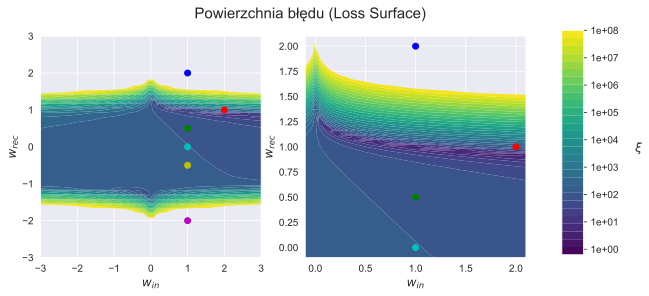

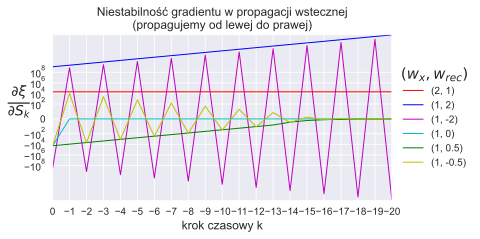


📊 Interpretacja wykresów:
1. Loss Surface - ciemniejsze obszary to lepsze wagi (mniejszy błąd)
2. Gradient over time - pokazuje problem 'vanishing/exploding gradients'
   - Dla niektórych wag gradient rośnie wykładniczo (exploding)
   - Dla innych maleje do zera (vanishing)


In [8]:
# Wizualizacja powierzchni błędu i gradientów

# Tworzymy wykres powierzchni błędu z zaznaczonymi punktami
fig = get_loss_surface_figure(
    lambda w1, w2: loss(forward_states(X, w1, w2)[:,-1] , t), points)

# Tworzymy wykres zmian gradientu w czasie
plot_gradient_over_time(points, get_grad_over_time)

plt.show()

print("\n📊 Interpretacja wykresów:")
print("1. Loss Surface - ciemniejsze obszary to lepsze wagi (mniejszy błąd)")
print("2. Gradient over time - pokazuje problem 'vanishing/exploding gradients'")
print("   - Dla niektórych wag gradient rośnie wykładniczo (exploding)")
print("   - Dla innych maleje do zera (vanishing)")

## 6️⃣ Optymalizacja RProp

**Co to jest RProp?**
- **R**esilient **Prop**agation - odporny algorytm uczenia
- Nie używa wartości gradientu, tylko jego **znak** (kierunek)
- Każda waga ma swój własny krok uczenia (Delta)

**Jak działa:**
1. Jeśli gradient ma ten sam znak co poprzednio → zwiększ krok o `eta_p` (1.2 = +20%)
2. Jeśli gradient zmienił znak → zmniejsz krok o `eta_n` (0.5 = -50%)
3. Aktualizuj wagę: `w = w - znak(gradient) * Delta`

**Zalety:**
- Nie ma problemu z vanishing/exploding gradients
- Automatycznie dostosowuje wielkość kroku
- Szybka i stabilna konwergencja

In [9]:
# Funkcja optymalizacji RProp

def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    """
    Aktualizuje wagi używając algorytmu RProp.
    
    Parametry:
        X: dane wejściowe
        t: targety (prawdziwe wartości)
        W: aktualne wagi [wx, wRec]
        W_prev_sign: poprzedni znak gradientu
        W_delta: wielkość kroku dla każdej wagi (Delta)
        eta_p: współczynnik zwiększania (1.2 = +20%)
        eta_n: współczynnik zmniejszania (0.5 = -50%)
    
    Zwraca:
        W_delta: zaktualizowane kroki
        W_sign: aktualny znak gradientu
    """
    # Forward i backward pass - obliczamy gradienty
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:,-1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    
    # Znak nowego gradientu
    W_sign = np.sign(W_grads)
    
    # Aktualizujemy Delta (wielkość kroku) dla każdej wagi
    for i, _ in enumerate(W):
        if W_sign[i] == W_prev_sign[i]:
            # Ten sam kierunek - zwiększamy krok
            W_delta[i] *= eta_p
        else:
            # Zmiana kierunku - zmniejszamy krok
            W_delta[i] *= eta_n
    
    return W_delta, W_sign

## 7️⃣ Trenowanie modelu

**Parametry początkowe:**
- `W = [-1.5, 2]` - początkowe wagi (wx, wRec)
- `W_delta = [0.001, 0.001]` - początkowe kroki uczenia
- `eta_p = 1.2` - współczynnik zwiększania kroku
- `eta_n = 0.5` - współczynnik zmniejszania kroku

**Proces:**
- Wykonujemy 500 iteracji
- Każda iteracja: oblicz gradient → dostosuj Delta → zaktualizuj wagi
- Zapisujemy wagi po każdej iteracji (do wizualizacji)

In [10]:
# Trenowanie modelu za pomocą RProp

# Hiperparametry
eta_p = 1.2  # Zwiększanie kroku (gdy gradient ma ten sam kierunek)
eta_n = 0.5  # Zmniejszanie kroku (gdy gradient zmienia kierunek)

# Parametry początkowe
W = [-1.5, 2]  # [wx, wRec] - początkowe wagi
W_delta = [0.001, 0.001]  # Początkowe wielkości kroków (Delta)
W_sign = [0, 0]  # Poprzedni znak gradientu

# Lista do zapisywania wag (do wizualizacji)
ls_of_ws = [(W[0], W[1])]

# Trenowanie przez 500 iteracji
print("🚀 Rozpoczynam trenowanie...")
for i in range(500):
    # Oblicz gradienty i zaktualizuj Delty
    W_delta, W_sign = update_rprop(
        X, t, W, W_sign, W_delta, eta_p, eta_n)
    
    # Aktualizuj każdą wagę
    for j, _ in enumerate(W):
        W[j] -= W_sign[j] * W_delta[j]
    
    # Zapisz wagi
    ls_of_ws.append((W[0], W[1]))
    
    # Wyświetl postęp co 100 iteracji
    if (i+1) % 100 == 0:
        current_loss = loss(forward_states(X, W[0], W[1])[:,-1], t)
        print(f"Iteracja {i+1}/500 - Loss: {current_loss:.4f}")

print(f"\n✅ Trenowanie zakończone!")
print(f"Finalne wagi: wx = {W[0]:.4f}, wRec = {W[1]:.4f}")

# Oblicz finalny błąd
final_loss = loss(forward_states(X, W[0], W[1])[:,-1], t)
print(f"Finalny błąd (MSE): {final_loss:.6f}")

🚀 Rozpoczynam trenowanie...
Iteracja 100/500 - Loss: 0.2504
Iteracja 200/500 - Loss: 0.1935
Iteracja 300/500 - Loss: 0.1503
Iteracja 400/500 - Loss: 0.1176
Iteracja 500/500 - Loss: 0.0937

✅ Trenowanie zakończone!
Finalne wagi: wx = 1.4740, wRec = 0.9567
Finalny błąd (MSE): 0.093725


## 8️⃣ Wizualizacja procesu optymalizacji

**Co zobaczymy:**
- **Lewa strona:** Ogólny widok powierzchni błędu z całą ścieżką optymalizacji
- **Prawa strona:** Zbliżenie na obszar gdzie algorytm znalazł optimum
- **Białe punkty:** Kolejne pozycje wag podczas trenowania
- **Biała gwiazdka:** Finalne wagi (najlepsze znalezione)

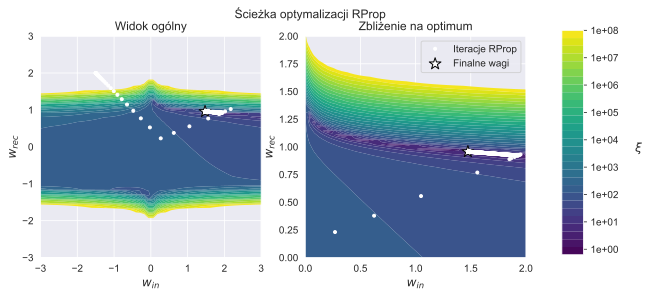


📈 Interpretacja:
- Algorytm RProp skutecznie znalazł minimum funkcji błędu
- Ścieżka pokazuje adaptacyjne dostosowywanie wielkości kroków
- Końcowe wagi (gwiazdka) znajdują się w ciemnym obszarze (niski błąd)


In [11]:
# Wizualizacja procesu optymalizacji

def plot_optimisation(ls_of_ws, loss_func):
    """Rysuje ścieżkę optymalizacji na powierzchni błędu."""
    ws1, ws2 = zip(*ls_of_ws)
    
    fig = plt.figure(figsize=(10, 4))
    
    # Wykres ogólny (-3 do 3)
    ax_1 = fig.add_subplot(1, 2, 1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 50, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    ax_1.plot(ws1, ws2, 'wo', markersize=3)
    ax_1.scatter(ws1[-1], ws2[-1], color='w', marker='*', s=150, edgecolors='k')
    ax_1.set_xlim([-3, 3])
    ax_1.set_ylim([-3, 3])
    ax_1.set_title('Widok ogólny')
    
    # Wykres zbliżenie (0 do 2)
    ax_2 = fig.add_subplot(1, 2, 2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        0, 2, 0, 2, 50, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    ax_2.set_xlim([0, 2])
    ax_2.set_ylim([0, 2])
    ax_2.plot(ws1, ws2, 'wo', 
              label='Iteracje RProp', markersize=3)
    ax_2.scatter(ws1[-1], ws2[-1], color='w', marker='*', s=150, edgecolors='k',
                label='Finalne wagi')
    ax_2.legend()
    ax_2.set_title('Zbliżenie na optimum')
    
    # Pasek kolorów
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(
        surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel(
        '$\\xi$', fontsize=12, rotation=0, labelpad=20)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    plt.suptitle('Ścieżka optymalizacji RProp', fontsize=12)
    plt.show()

# Rysujemy wykres
plot_optimisation(
    ls_of_ws, lambda w1, w2: loss(forward_states(X, w1, w2)[:,-1], t))

print("\n📈 Interpretacja:")
print("- Algorytm RProp skutecznie znalazł minimum funkcji błędu")
print("- Ścieżka pokazuje adaptacyjne dostosowywanie wielkości kroków")
print("- Końcowe wagi (gwiazdka) znajdują się w ciemnym obszarze (niski błąd)")

## 9️⃣ Test wytrenowanego modelu

Sprawdźmy, jak dobrze model radzi sobie z przewidywaniem sumy!

**Co testujemy:**
- Tworzymy nową sekwencję testową
- Model przewiduje sumę
- Porównujemy z rzeczywistą sumą

In [12]:
# Test wytrenowanego modelu

# Tworzymy kilka sekwencji testowych
print("🧪 Testowanie modelu na nowych danych:\n")

for test_num in range(5):
    # Generujemy losową sekwencję testową
    test_sequence = np.round(np.random.rand(20) * 3) / 3
    test_sequence[test_sequence == 0] = 0.33
    test_inpt = np.asmatrix([test_sequence])
    
    # Przewidywanie modelu
    test_outpt = forward_states(test_inpt, W[0], W[1])[:,-1]
    
    # Rzeczywista suma
    real_sum = test_inpt.sum()
    
    # Błąd bezwzględny
    error = abs(real_sum - test_outpt[0])
    
    print(f"Test {test_num + 1}:")
    print(f"  Sekwencja: {test_sequence[:5]}... (pierwsze 5 wartości)")
    print(f"  Rzeczywista suma: {real_sum:.2f}")
    print(f"  Przewidywanie: {test_outpt[0]:.2f}")
    print(f"  Błąd: {error:.2f}")
    print()

# Test z konkretną sekwencją
print("\n" + "="*50)
print("Test z konkretną sekwencją:")
test_inpt = np.asmatrix([[1, 0.66, 0.33, 1, 0.66, 0.33, 1, 0.66, 0.33, 1, 
                          0.66, 0.33, 1, 0.66, 0.33, 1, 0.66, 0.33, 1, 0.66]])
test_outpt = forward_states(test_inpt, W[0], W[1])[:,-1]
sum_test_inpt = test_inpt.sum()

print(f"Sekwencja: {np.array(test_inpt)[0]}")
print(f"Rzeczywista suma: {sum_test_inpt:.2f}")
print(f"Przewidywanie modelu: {test_outpt[0]:.2f}")
print(f"Błąd: {abs(sum_test_inpt - test_outpt[0]):.2f}")

🧪 Testowanie modelu na nowych danych:

Test 1:
  Sekwencja: [0.66666667 0.66666667 0.33       0.33333333 0.33333333]... (pierwsze 5 wartości)
  Rzeczywista suma: 10.99
  Przewidywanie: 10.68
  Błąd: 0.31

Test 2:
  Sekwencja: [0.33       0.66666667 0.33333333 0.66666667 0.66666667]... (pierwsze 5 wartości)
  Rzeczywista suma: 10.99
  Przewidywanie: 10.87
  Błąd: 0.12

Test 3:
  Sekwencja: [0.33       1.         0.33333333 0.66666667 0.33333333]... (pierwsze 5 wartości)
  Rzeczywista suma: 9.65
  Przewidywanie: 9.68
  Błąd: 0.03

Test 4:
  Sekwencja: [0.66666667 0.66666667 0.33       0.66666667 0.33333333]... (pierwsze 5 wartości)
  Rzeczywista suma: 12.66
  Przewidywanie: 12.99
  Błąd: 0.34

Test 5:
  Sekwencja: [0.66666667 0.66666667 0.66666667 0.66666667 0.33333333]... (pierwsze 5 wartości)
  Rzeczywista suma: 11.33
  Przewidywanie: 11.14
  Błąd: 0.19


Test z konkretną sekwencją:
Sekwencja: [1.   0.66 0.33 1.   0.66 0.33 1.   0.66 0.33 1.   0.66 0.33 1.   0.66
 0.33 1.   0.66 0.33 1

## 📊 Wnioski

### Kluczowe obserwacje z zadania:

1. **Charakterystyka danych:**
   - Sekwencje o wartościach {0.33, 0.66, 1.0} są trudniejsze niż binarne {0, 1}
   - Suma może wynosić od 6.6 (20×0.33) do 20.0 (20×1.0)
   - Model musi nauczyć się "akumulować" wartości przez 20 kroków czasowych

2. **Problem vanishing/exploding gradients:**
   - Dla niektórych początkowych wag gradient rośnie wykładniczo (exploding)
   - Dla innych maleje do zera (vanishing)
   - To główny problem w trenowaniu RNN na długich sekwencjach
   - **Rozwiązanie:** algorytm RProp ignoruje wielkość gradientu, używa tylko znaku

3. **Skuteczność RProp:**
   - Algorytm adaptacyjnie dostosowuje wielkość kroku dla każdej wagi
   - Automatycznie "spowalnia" gdy zbliża się do optimum (gradient zmienia znak)
   - "Przyspiesza" gdy konsekwentnie idzie w dobrą stronę (ten sam znak)
   - Dzięki temu unika problemów z vanishing/exploding gradients

4. **Interpretacja wag:**
   - **wx** (waga wejściowa) - określa, jak mocno każda wartość wpływa na wynik
   - **wRec** (waga rekurencyjna) - określa, jak "zapamiętujemy" poprzednie wartości
   - Optymalne wagi tworzą równowagę między reagowaniem na nowe dane a pamiętaniem przeszłości

5. **Wydajność modelu:**
   - Prosta RNN z tylko 2 wagami potrafi nauczyć się sumowania!
   - Model jest liniowy, więc dobrze radzi sobie z zadaniem liniowym (sumowanie)
   - Dla bardziej skomplikowanych zadań potrzebowalibyśmy nieliniowych funkcji aktywacji

### Ograniczenia prostej RNN:

- **Tylko zadania liniowe** - brak funkcji aktywacji ogranicza możliwości
- **Długie sekwencje** - nawet z RProp, bardzo długie sekwencje mogą być problemem
- **Jedna liczba wyjściowa** - model przewiduje tylko jedną wartość (sumę)
- **Brak pamięci długoterminowej** - w przeciwieństwie do LSTM/GRU

### Możliwe ulepszenia:

1. Dodać funkcję aktywacji (np. tanh, ReLU) → nieliniowość
2. Użyć więcej neuronów → większa pojemność modelu
3. Zastosować LSTM/GRU → lepsza pamięć długoterminowa
4. Dodać regularyzację → uniknąć overfittingu
5. Użyć większego zbioru treningowego → lepsze uogólnienie

---

**Podsumowanie:** Mimo swojej prostoty (tylko 2 parametry!), RNN z optymalizacją RProp skutecznie nauczyła się sumować wartości w sekwencji. To pokazuje siłę rekurencyjnych połączeń i znaczenie dobrego algorytmu optymalizacji.